Parameters:
t = 360 meV
t' = -100 meV (next-nearest neighbor hopping)
t'' = 35 meV (etc.)
t''' = 10 meV 
t_z = 36 meV (interlayer hopping)
t_bi = 110 meV (bond-charge interaction)

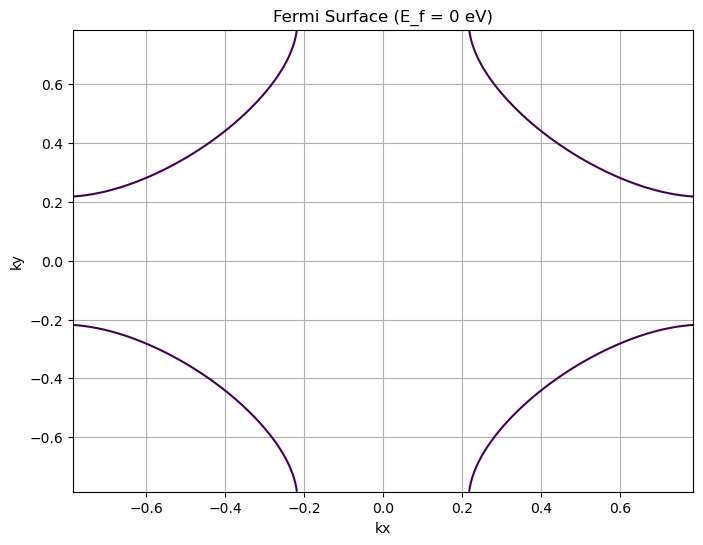

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Tight-binding parameters
t = 360e-3  # eV
t_prime = -100e-3  # eV
t_double_prime = 35e-3  # eV
a_lattice = 3.85

#Square lattice
def dispersion_relation(kx, ky, lattice_constant):
    nearest_neighbor = -2 * t * (np.cos(lattice_constant*kx) + np.cos(lattice_constant*ky))
    next_nearest = -4 * t_prime * np.cos(lattice_constant*kx) * np.cos(lattice_constant*ky) 
    next_next_nearest = +t_double_prime * (np.cos(2 * lattice_constant*kx) + np.cos(2 * lattice_constant*ky))
    
    return nearest_neighbor + next_nearest + next_next_nearest

kx = np.linspace(-np.pi, np.pi, 100)/4
ky = np.linspace(-np.pi, np.pi, 100)/4
kx_grid, ky_grid = np.meshgrid(kx, ky)

fermi_energy = 0

# Compute the dispersion relation
ek = dispersion_relation(kx_grid, ky_grid, a_lattice)

plt.figure(figsize=(8, 6))
plt.contour(kx_grid, ky_grid, ek, levels=[fermi_energy])
plt.xlabel('kx')
plt.ylabel('ky')
plt.title(f'Fermi Surface (E_f = {fermi_energy} eV)')
plt.grid(True)


In [318]:
from arpes.io import load_data
from arpes.utilities.conversion import convert_to_kspace
import lmfit

import os.path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import math
import numpy as np
import xarray as xr
import fft_PSI


In [319]:
# Define directory
path = os.path.abspath(('/Users/iansackin/Library/CloudStorage/Box-Box/'+
                        'REU_Ian/ARPES_data_Bi2223/Box_1_square_renamed/'))

# Different parameters used to set up scans at SLS
scan_type = 'FS'
direction = 'AN'
phi = 'P5'
energy = '25eV'
polarization = 'CIRCP'
temp = 'HT'
e_pass = '10'+'eVpass'
comment = ''
run = '*'.zfill(4)

# Put together string for finding file
parameters = [scan_type, direction, phi, energy, polarization, temp, e_pass, comment, run]
if comment == '':
    parameters.remove(comment)
file_type = 'h5'
file_name = '_'.join(parameters)
file = '.'.join([file_name , file_type])

full_file = os.path.join(path, file)
file

'FS_AN_P5_25eV_CIRCP_HT_10eVpass_000*.h5'

In [320]:
import glob
# Load all files with above specified parameters, * is a placeholder and imports all files in its place
files = glob.glob(full_file)
print('Files found: '+str(len(files)))

Files found: 1


In [638]:
data = load_data(files[0], location="ULTRA")

In [322]:
fs = data.spectrum

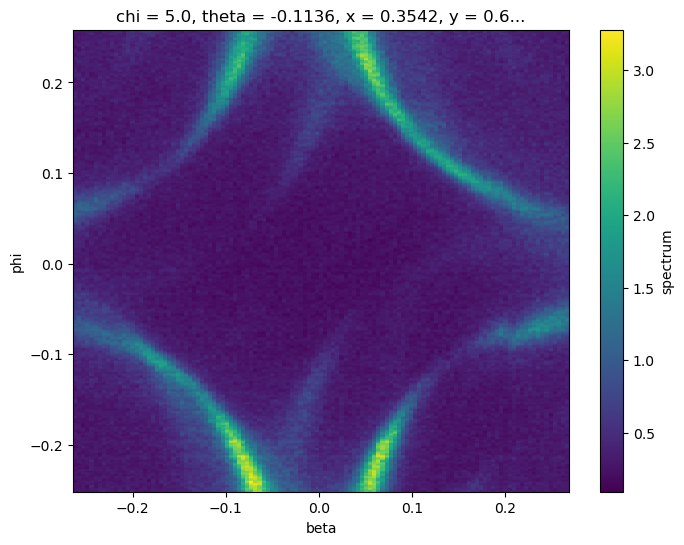

In [616]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

fs.S.fermi_surface.plot(ax=ax)
ax.contour(kx_grid, ky_grid, ek, levels=[fermi_energy], colors='r')

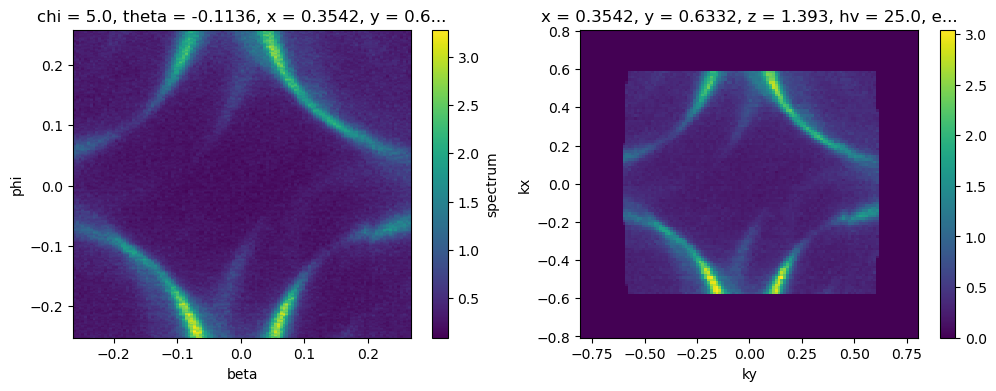

In [324]:
#Fitting Parameters to Fermi Surface
from arpes.utilities.conversion import convert_to_kspace

fig, axes = plt.subplots(1, 2, figsize=(12,4))

fs.S.fermi_surface.plot(ax=axes[0])
kspace_fs = convert_to_kspace(
    fs,
    kx = np.linspace(-0.8,0.8,120),
    ky = np.linspace(-0.8,0.8,120),
)

kspace_fs.S.fermi_surface.plot(ax=axes[1])

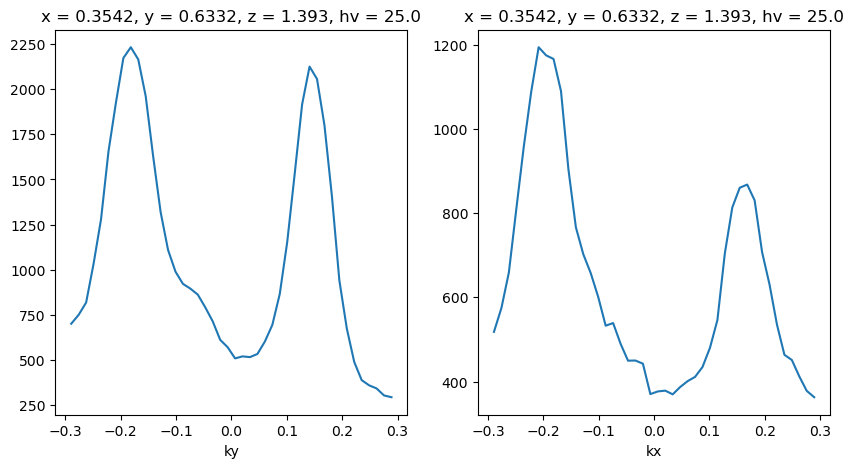

In [325]:
#Shifting gamma point to (0,0)
fig, axes = plt.subplots(1, 2, figsize=(10,5))

ky_cut = kspace_fs.sel(ky=slice(-0.3,0.3), eV=slice(-0.03,0.03), kx=slice(None,-0.4)).sum('kx').sum('eV')
kx_cut = kspace_fs.sel(kx=slice(-0.3,0.3), eV=slice(-0.03,0.03), ky=slice(None,-0.4)).sum('ky').sum('eV')
ky_cut.S.plot(ax=axes[0]) 
kx_cut.S.plot(ax=axes[1])

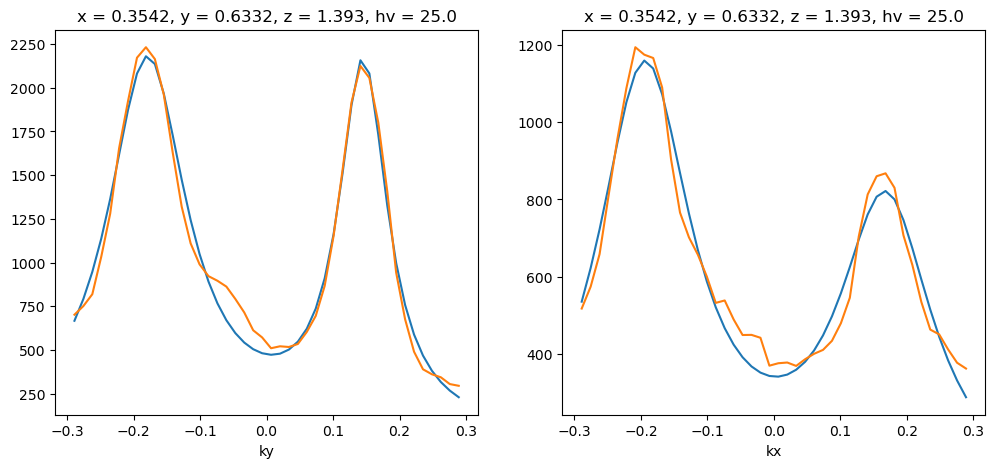

In [326]:
from lmfit.models import LorentzianModel
alignment_model = LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')
params = alignment_model.make_params(
    p1_center = -0.2, p1_sigma = 0.1, p1_amplitude = 2000,
    p2_center = 0.15, p2_sigma = 0.1, p2_amplitude = 2000
)

kx_cut_fit = alignment_model.fit(kx_cut.values, params, x=kx_cut['kx'])
ky_cut_fit = alignment_model.fit(ky_cut.values, params, x=ky_cut['ky'])

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].plot(ky_cut['ky'], ky_cut_fit.best_fit)
ky_cut.S.plot(ax=axes[0]) 
axes[1].plot(kx_cut['kx'], kx_cut_fit.best_fit)
kx_cut.S.plot(ax=axes[1]) 


In [327]:
kx_cut['kx'][kx_cut_fit.best_fit.argmax()]

<xarray.DataArray 'kx' ()>
array(-0.19495798)
Coordinates:
    kx       float64 -0.195
    x        float64 0.3542
    y        float64 0.6332
    z        float64 1.393
    hv       float64 25.0

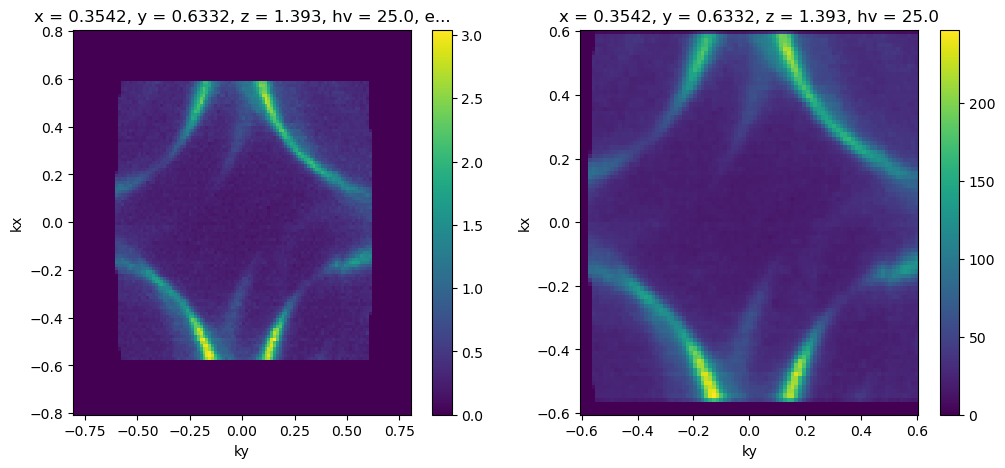

In [439]:
#Shifting and realignment to coordinate window
fig, axes = plt.subplots(1,2, figsize=(12,5))

kspace_fs = convert_to_kspace(
    fs,
    kx = np.linspace(-0.8,0.8,120),
    ky = np.linspace(-0.8,0.8,120),
)

kspace_fs.S.fermi_surface.plot(ax=axes[0])

ky_range = ky_cut.ky[-1] - ky_cut.ky[0]
ky_max_1 = ky_cut['ky'][ky_cut_fit.best_fit[:int(len(ky_cut_fit.best_fit)/2)].argmax()]
ky_max_2 = ky_cut['ky'][ky_cut_fit.best_fit[int(len(ky_cut_fit.best_fit)/2):].argmax()] + ky_range/2
ky_center = float((ky_max_1 + ky_max_2)/2)

kx_range = kx_cut.kx[-1] - kx_cut.kx[0]
kx_max_1 = kx_cut['kx'][kx_cut_fit.best_fit[0:int(len(kx_cut_fit.best_fit)/2)].argmax()]
kx_max_2 = kx_cut['kx'][kx_cut_fit.best_fit[int(len(kx_cut_fit.best_fit)/2):].argmax()] + kx_range/2
kx_center = float((kx_max_1 + kx_max_2)/2)

ky_shift = xr.DataArray(
    ky_center * np.ones(len(kspace_fs.eV)), 
    dims='eV', 
    coords={"eV": np.array(kspace_fs.eV)}
)
kx_shift = xr.DataArray(
    kx_center * np.ones(len(kspace_fs.eV)), 
    dims='eV', 
    coords={"eV": np.array(kspace_fs.eV)}
)
kspace_fs = kspace_fs.G.shift_by(
    ky_shift,
    shift_axis = 'ky'
).G.shift_by(
    kx_shift,
    shift_axis = 'kx'
)


kspace_fs = kspace_fs.sel(
    ky = slice(-0.6,0.6),
    kx = slice(-0.6,0.6)
)

kspace_fs.sel(eV=slice(-0.03,0.03)).sum('eV').S.plot(ax=axes[1])

In [440]:
kx = np.linspace(-0.,0.6,90)
ky = np.linspace(-0.6,0.6,90)
kx_grid, ky_grid = np.meshgrid(kx, ky)

fermi_energy = 0.0
a_lattice = 3.85

def dispersion_fit(params, kx, ky, lc, data=None):
    t = params['t']
    t_prime = params['t_prime']
    t_double_prime = params['t_double_prime']
    
    nearest_neighbor = -2 * t * (np.cos(lc*kx) + np.cos(lc*ky))
    next_nearest = -4 * t_prime * np.cos(lc*kx) * np.cos(lc*ky) 
    next_next_nearest = + t_double_prime * (np.cos(2 * lc*kx) + np.cos(2 * lc*ky))

    model = nearest_neighbor + next_nearest + next_next_nearest

    if data is None:
        return model
    else:
        return model - data



In [441]:
#Initial parameter values
pars = lmfit.Parameters()
pars.add('t', value=360e-3)
pars.add('t_prime', value=-100e-3)
pars.add('t_double_prime', value=35e-3)

In [442]:
pars

name,value,min,max,stderr,vary,expr,brute_step
t,0.360,-inf,inf,inf,True,,
t_double_prime,0.035,-inf,inf,inf,True,,
t_prime,-0.100,-inf,inf,inf,True,,


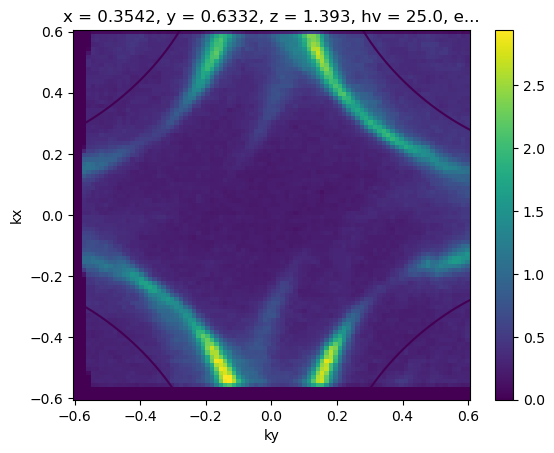

In [617]:
ek = dispersion_fit(pars, kx_grid, ky_grid, a_lattice)
plt.contour(kx_grid, ky_grid, ek, levels=[fermi_energy])
kspace_fs.S.fermi_surface.plot()

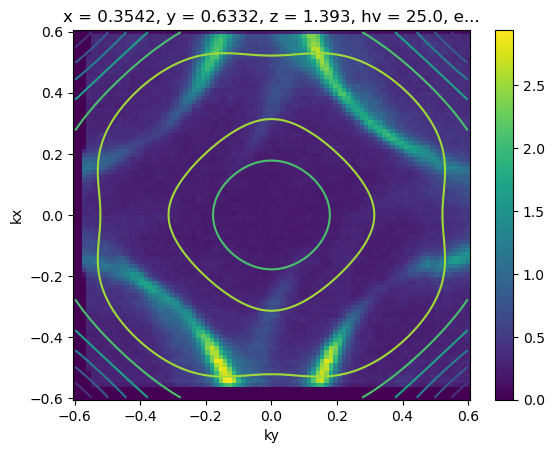

In [620]:
#Fitting to Data
KX, KY = np.meshgrid(kspace_fs.kx, kspace_fs.ky)
result = lmfit.minimize(dispersion_fit, pars, args=(KX, KY, a_lattice, kspace_fs))
ek = dispersion_fit(result.params, KX, KY, a_lattice)

#Rotation stuff, probably unnecessary
angle = 45 * np.pi/180
rotation_matrix = np.array([
    [np.cos(angle), -np.sin(angle)],
    [np.sin(angle), np.cos(angle)]
])
# KX, KY = np.einsum('ji, mni -> jmn', rotation_matrix, np.dstack([KX, KY]))

kspace_fs.S.fermi_surface.plot(cmap='viridis')
plt.contour(KX, KY, ek)

In [621]:
result.params

name,value,min,max,stderr,vary,expr,brute_step
fermi_energy,0.000,-inf,inf,inf,True,,
t,-0.288,-inf,inf,inf,True,,
t_double_prime,-0.249,-inf,inf,inf,True,,
t_prime,0.152,-inf,inf,inf,True,,
t_triple_prime,0.010,-inf,inf,inf,True,,


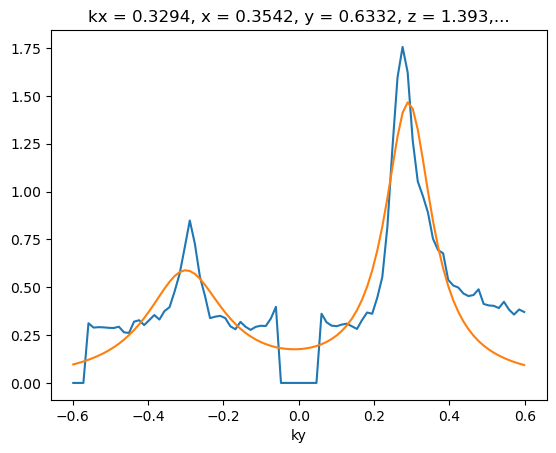

In [601]:
edc = kspace_fs.S.fermi_surface.sel(kx, method='nearest')

edc.sel(ky=slice(-0.05,0.05))[:] = 0

alignment_model = LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')
params = alignment_model.make_params(
    p1_center = -0.3, p1_sigma = 0.1, p1_amplitude = 1,
    p2_center = 0.3, p2_sigma = 0.1, p2_amplitude = 1
)

edc_fit = alignment_model.fit(edc.values, params, x=edc['ky'])
edc.S.plot()
plt.plot(edc.ky, edc_fit.best_fit)

152
137


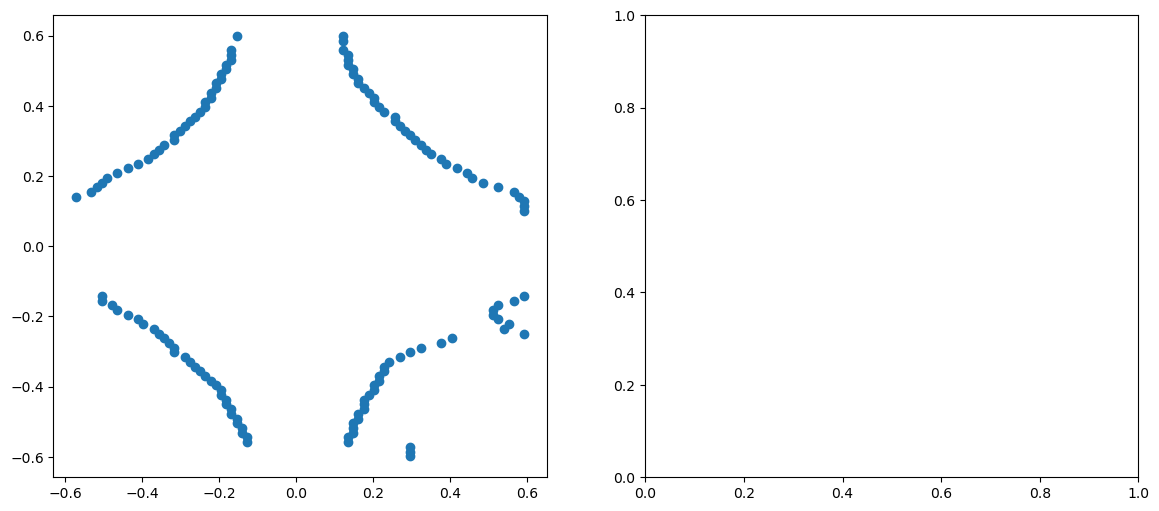

In [602]:
from lmfit.models import LorentzianModel
import xarray as xr

fermi_surface_points = []
for kx in kspace_fs.kx:

    if abs(kx) < 0.09:
        continue
    
    cut = kspace_fs.S.fermi_surface.sel(kx=kx, method='nearest')
    cut.sel(ky=slice(-0.05,0.05))[:] = 0 #gets rid of higher order term influences
    
    alignment_model = LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')
    params = alignment_model.make_params(
        p1_center = -0.3, p1_sigma = 0.1, p1_amplitude = 1,
        p2_center = 0.3, p2_sigma = 0.1, p2_amplitude = 1
    )
    
    cut_fit = alignment_model.fit(cut.values, params, x=cut['ky'])

    cut_range = cut.ky[-1] - cut.ky[0]
    cut_max_1 = cut['ky'][cut_fit.best_fit[:int(len(cut_fit.best_fit)/2)].argmax()]
    cut_max_2 = cut['ky'][cut_fit.best_fit[int(len(cut_fit.best_fit)/2):].argmax()] + cut_range/2

    fermi_surface_points.append(np.array([cut_max_1, kx, fermi_energy]))
    fermi_surface_points.append(np.array([cut_max_2, kx, fermi_energy]))

#Going along other axis to correct for outliers
"""
fs_ky_pts = []
for i, ky in enumerate(kspace_fs.ky):

    if abs(ky) < 0.12:
        continue
    
    cut = kspace_fs.S.fermi_surface.sel(ky=ky, method='nearest')
    cut.sel(kx=slice(-0.05,0.05))[:] = 0 #gets rid of higher order term influences
    
    alignment_model = LorentzianModel(prefix='p1_') + LorentzianModel(prefix='p2_')
    params = alignment_model.make_params(
        p1_center = -0.3, p1_sigma = 0.1, p1_amplitude = 1,
        p2_center = 0.3, p2_sigma = 0.1, p2_amplitude = 1
    )
    
    cut_fit = alignment_model.fit(cut.values, params, x=cut['kx'])

    cut_range = cut.kx[-1] - cut.kx[0]
    cut_max_1 = cut['kx'][cut_fit.best_fit[:int(len(cut_fit.best_fit)/2)].argmax()]
    cut_max_2 = cut['kx'][cut_fit.best_fit[int(len(cut_fit.best_fit)/2):].argmax()] + cut_range/2

    fs_ky_pts.append(np.array([ky, cut_max_1]))
    fs_ky_pts.append(np.array([ky, cut_max_2]))
"""
print(len(fermi_surface_points))
fermi_surface_points.pop(76)
fermi_surface_points.pop(75)
fermi_surface_points.pop(74)
fermi_surface_points.pop(73)
fermi_surface_points.pop(72)
fermi_surface_points.pop(71)
fermi_surface_points.pop(142)
fermi_surface_points.pop(141)
fermi_surface_points.pop(140)
for i, point in enumerate(fermi_surface_points):
    if abs(point[0]) < 0.05:
        fermi_surface_points.pop(i)
    if abs(point[1]) < 0.13:
        fermi_surface_points.pop(i)


print(len(fermi_surface_points))

fermi_surface_points = np.array(fermi_surface_points)


# fs_ky_pts = np.array(fs_ky_pts)

fig, axes = plt.subplots(1, 2, figsize=(14,6))

axes[0].scatter(fermi_surface_points[:,0], fermi_surface_points[:,1])
# axes[1].scatter(fs_ky_pts[:,0], fs_ky_pts[:,1])

In [622]:
# fermi_surface_points

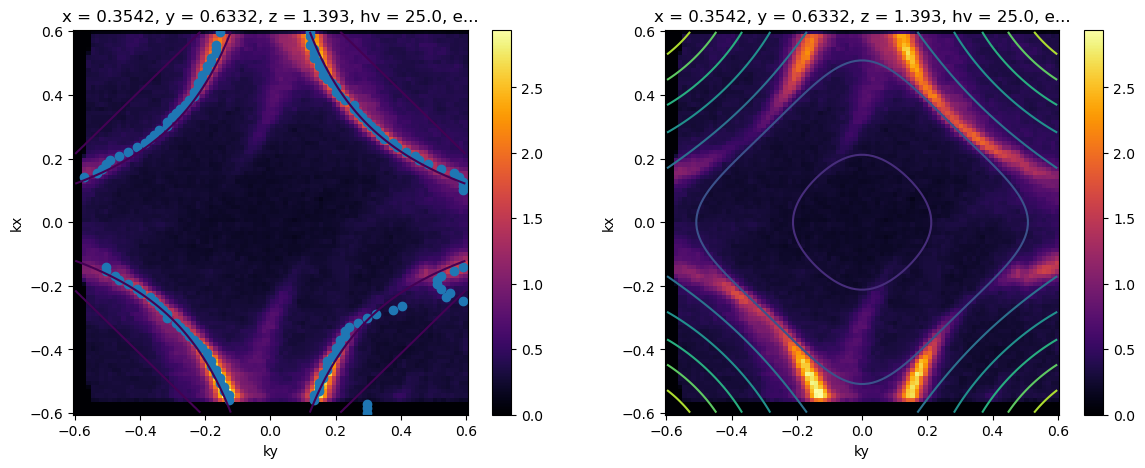

In [634]:
#ATTEMPT 2, Finding max data, then fitting to those points
a_lattice = 3.85

#Initial parameter values
pars = lmfit.Parameters()
pars.add('t', value=360e-3)
pars.add('t_prime', value=-100e-3)
pars.add('t_double_prime', value=35e-3)
pars.add('t_triple_prime', value = 10e-3)
pars.add('fermi_energy', value=0)

def dispersion_model(params, kx, ky, lc, mu):
    t = params['t']
    t_prime = params['t_prime']
    t_double_prime = params['t_double_prime']
    t_triple_prime = params['t_triple_prime']
    mu = params['fermi_energy']
    
    nearest_neighbor = -2 * t * (np.cos(lc*kx) + np.cos(lc*ky))
    next_nearest = -4 * t_prime * np.cos(lc*kx) * np.cos(lc*ky) 
    next_next_nearest = t_double_prime * (np.cos(2 * lc*kx) + np.cos(2 * lc*ky))
    fourth_nearest = t_triple_prime*(np.cos(2*lc*kx)*np.cos(lc*ky) + np.cos(2*lc*ky)*np.cos(lc*kx))

    return nearest_neighbor + next_nearest + next_next_nearest + fourth_nearest - mu

def objective(params, kx, ky, lc, mu, data):
    model = dispersion_model(params, kx, ky, lc, energy_data)
    return model - data

kx_data = fermi_surface_points[:,1]
ky_data = fermi_surface_points[:,0]
energy_data = fermi_surface_points[:,2]

result = lmfit.minimize(objective, pars, args=(kx_data, ky_data, a_lattice, fermi_energy, energy_data), method='cg')

initial = dispersion_model(pars, KX, KY, a_lattice, fermi_energy)
best_fit = dispersion_model(result.params, KX, KY, a_lattice, fermi_energy)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].contour(KX, KY, best_fit, levels=[fermi_energy])
axes[1].contour(KX, KY, initial)
kspace_fs.S.fermi_surface.plot(cmap='inferno', ax=axes[0])
kspace_fs.S.fermi_surface.plot(cmap='inferno', ax=axes[1])
axes[0].scatter(fermi_surface_points[:,0], fermi_surface_points[:,1])

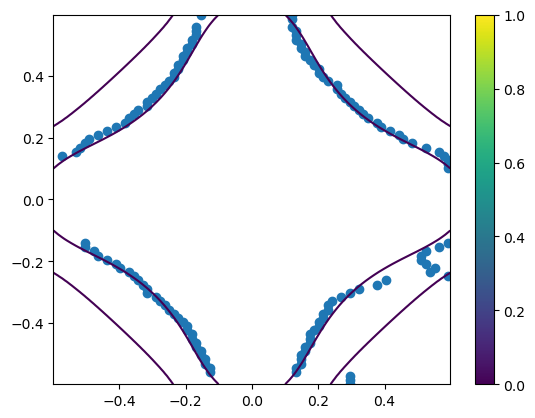

In [627]:
plt.contour(KX, KY, best_fit, levels=[0])
plt.scatter(fermi_surface_points[:,0], fermi_surface_points[:,1])
plt.colorbar()

In [628]:
result

In [629]:
pars

name,value,min,max,stderr,vary,expr,brute_step
fermi_energy,0.000,-inf,inf,inf,True,,
t,3.600,-inf,inf,inf,True,,
t_double_prime,0.035,-inf,inf,inf,True,,
t_prime,-0.100,-inf,inf,inf,True,,
t_triple_prime,0.010,-inf,inf,inf,True,,


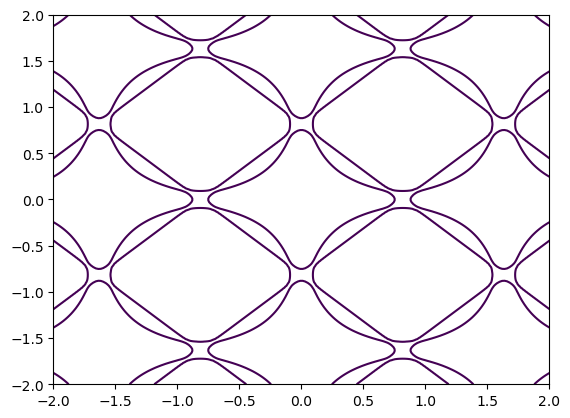

In [633]:
xs = np.linspace(-2,2,200)
ys = np.linspace(-2,2,200)
xs, ys = np.meshgrid(xs,ys)
test_fit = dispersion_model(result.params, xs, ys, a_lattice, fermi_energy)

plt.contour(xs, ys, test_fit, levels=[fermi_energy])

SystemExit: 0

/Users/iansackin/miniconda3/envs/arpes/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
